In [68]:
from gnn_tracking.training.ec import ECModule

import scienceplots

import matplotlib.pyplot as plt

plt.style.use(("science", "notebook"))

In [4]:
module = ECModule.load_from_checkpoint(
    "/home/kl5675/Documents/23/git_sync/hyperparameter_optimization2/scripts/legacy/lightning_logs/fanatic-cyber-hyrax/checkpoints/epoch=18-step=136800.ckpt",
    map_location="cpu"
)

[06:38:19] DEBUG: Getting class ECForGraphTCN from module gnn_tracking.models.edge_classifier
[06:38:19] DEBUG: Getting class HaughtyFocalLoss from module gnn_tracking.metrics.losses


In [106]:
from gnn_tracking.utils.loading import TrackingDataModule

dm = TrackingDataModule(
    train=dict(
        dirs=[
            "/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/graphs_v5_cut/part_1/"
        ],
    ),
    val=dict(
        dirs=[
            "/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/graphs_v5_cut/part_9/"
        ],
        stop=5
    ),
)
dm.setup(stage="fit")

[07:35:30] INFO: DataLoader will load 28798 graphs (out of 28798 available).
[07:35:30] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/graphs_v5_cut/part_1/data21000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/graphs_v5_cut/part_1/data21999_s9.pt
[07:35:30] INFO: DataLoader will load 5 graphs (out of 32000 available).
[07:35:30] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/graphs_v5_cut/part_9/data29000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/graphs_v5_cut/part_9/data29000_s12.pt


In [18]:
import networkx as nx
from torch import Tensor as T


# data =dm.datasets["val"][0]

In [8]:
from gnn_tracking.metrics.cluster_metrics import tracking_metrics, TrackingMetrics
from torch_geometric.data import Data
from typing import Iterable


In [32]:
from gnn_tracking.analysis.graphs import get_cc_labels
import pandas as pd
from gnn_tracking.metrics.cluster_metrics import flatten_track_metrics, \
    tracking_metrics_data


def _get_cc_stats(data, module, cutoffs):
    results = []
    weights = module(data)["W"]
    for cutoff in cutoffs:
        dc = data.edge_subgraph(weights > cutoff)
        labels = get_cc_labels(dc.edge_index, num_nodes=data.num_nodes)
        r= flatten_track_metrics(
            tracking_metrics_data(
                dc, labels.detach().cpu().numpy(), [0.9]
            )
        )
        r["thld"] = cutoff
        results.append(r)
    return pd.DataFrame.from_records(results)


def get_cc_stats(module, dataloader, cutoffs):
    results = []
    for data in dataloader:
        results.append(_get_cc_stats(data, module, cutoffs))
    dfs_concat = pd.concat(results)
    return dfs_concat.groupby("thld").agg(["mean", "std"]).reset_index()

In [63]:
import numpy as np

df = get_cc_stats(module, dm.val_dataloader(), np.linspace(0.1, 0.9, 50))

In [65]:
df.columns = ["_".join(c) if c[1] else c[0] for c in df.columns.values]

In [100]:
def get_best_truth_metrics(dataloader):
    results = []
    for data in dataloader():
        ei = data.edge_index
        y = data.y.bool()
        tl = get_cc_labels(ei[:, y], num_nodes=data.num_nodes).long()
        r = tracking_metrics_data(data, tl.detach().cpu().numpy(), [0.9])
        results.append(flatten_track_metrics(r))
    return pd.DataFrame.from_records(results).mean()

In [97]:
dft = get_best_truth_metrics(dm.val_dataloader())

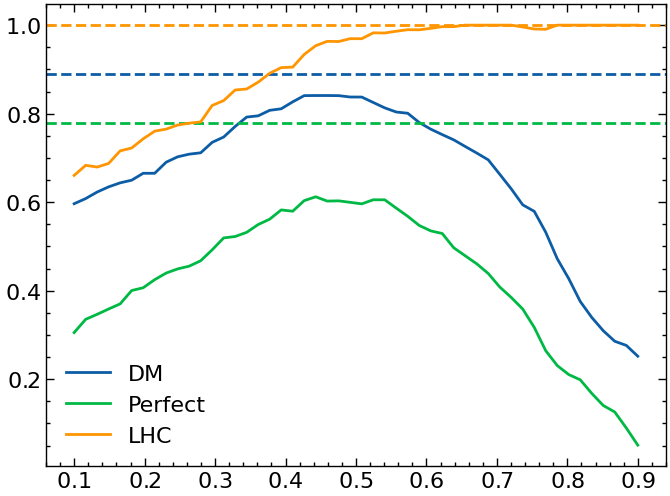

In [115]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots()
ax.plot("thld", "double_majority_pt0.9_mean", data=df, label="DM", c="C0")
ax.axhline(dft2["double_majority_pt0.9"], c="C0", ls="--")
ax.plot("thld", "perfect_pt0.9_mean", data=df, label="Perfect", c="C1")
ax.axhline(dft2["perfect_pt0.9"], c="C1", ls="--")
ax.plot("thld", "lhc_pt0.9_mean", data=df, label="LHC", c="C2")
ax.axhline(dft2["lhc_pt0.9"], c="C2", ls="--")
ax.legend()

In [43]:
df[("perfect_pt0.9", "mean")].max()

0.6121489943937127

In [111]:
from gnn_tracking.utils.loading import TrackingDataModule

dm2 = TrackingDataModule(
    train=dict(
        dirs=[
            "/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/graphs_v5/part_1/"
        ],
    ),
    val=dict(
        dirs=[
            "/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/graphs_v5/part_9/"
        ],
        stop=5
    ),
)
dm2.setup(stage="fit")

[07:36:13] INFO: DataLoader will load 28800 graphs (out of 28800 available).
[07:36:13] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/graphs_v5/part_1/data21000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/graphs_v5/part_1/data21999_s9.pt
[07:36:13] INFO: DataLoader will load 5 graphs (out of 32000 available).
[07:36:13] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/graphs_v5/part_9/data29000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/graphs_v5/part_9/data29000_s12.pt


In [113]:
dft2 = get_best_truth_metrics(dm2.val_dataloader)

In [114]:
dft2

n_particles_pt0.9             66.600000
n_cleaned_clusters_pt0.9      61.400000
perfect_pt0.9                  0.778642
double_majority_pt0.9          0.889590
lhc_pt0.9                      1.000000
fake_perfect_pt0.9             0.144620
fake_double_majority_pt0.9     0.033672
fake_lhc_pt0.9                 0.000000
dtype: float64